## Training an Autoencoder With TensorNodes

When working with TensorNodes you can train them just like normal parts of a Nengo model. The only deviation from the standard procedure is the definition of the custom classes which encapsulate the TensorFlow portions. 

In this example we will illustrate this trainability by training an autoencoder on the MNIST dataset. The autoencoder takes the input in with a dimensionality of `784` (28\*28) and reduces it to a dimensionality of `36`. This is the encoding phase where the network is effectively compressing the input. The decode phase then takes that `36` dimensional representation and attempts to reconstruct the original input with it.

We show at the bottom of the notebook how the training changes the output. The output starts off as pure noise and gradually looks more and more like the input.

In [8]:
%matplotlib inline

import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The network architecture consists of one input layer followed by 4 densely connected layers. The layers architecture is mirrored such that:

```
Layer 1: 784 Elements - Input
Layer 2: 128 Elements - Encode 1
Layer 3: 36 Elements - Encode 2
Layer 4: 128 Elements - Decode 1
Layer 5: 784 Elements - Decode 2/Output
```

In [10]:
# Network Parameters
n_hidden_1 = 128 # 1st layer num features
n_hidden_2 = 36 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

The TensorNodes are broken up into two classes: an Encoder, which compresses the input, and a Decoder, which decompresses the output to attempt to recreate the original.

Both of the TensorNode types consist of two fully connected (dense) layers which are in turn connected to each other

In [11]:
# Building the encoder
class Encoder(object):
    def pre_build(self, shape_in, shape_out):
        self.n_mini = shape_in[0]
        self.size_in = shape_in[1]
        self.size_out = shape_out[1]
        
    
    def __call__(self, t, x):    
        dense = tf.contrib.layers.fully_connected(x, n_hidden_1)
        dense = tf.contrib.layers.fully_connected(dense, n_hidden_2)

        return dense


# Building the encoder
class Decoder(object):
    def pre_build(self, shape_in, shape_out):
        self.n_mini = shape_in[0]
        self.size_in = shape_in[1]
        self.size_out = shape_out[1]
    
    def __call__(self, t, x):    
        dense = tf.contrib.layers.fully_connected(x, n_hidden_1)
        dense = tf.contrib.layers.fully_connected(dense, self.size_out)

        return dense


with nengo.Network() as net:
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    
     # create node to feed in images
    inp = nengo.Node(nengo.processes.PresentInput(mnist.test.images, 0.001))
    
    # create TensorNodes to insert into the network
    tf_encode = nengo_dl.TensorNode(Encoder(), size_in=n_input, size_out=n_hidden_2, label='H1')
    tf_decode = nengo_dl.TensorNode(Decoder(), size_in=n_hidden_2, size_out=n_input, label='H2')
    
    # connecting all the nodes together
    nengo.Connection(inp, tf_encode)
    nengo.Connection(tf_encode, tf_decode)
    
    # defining probes
    input_probe = nengo.Probe(inp)
    encode_probe = nengo.Probe(tf_encode)
    decode_probe = nengo.Probe(tf_decode)

Luckily for this network the training data for output and input are the same, therefore the same data can be used for both.

In [12]:
train_inputs = {inp: mnist.train.images[:, None, :]}
train_targets = {decode_probe: train_inputs[inp]}
test_inputs = {inp: mnist.test.images[:, None, :]}
test_targets = {decode_probe: test_inputs[inp]}

We break the training up into single epochs so that we can visualize the effect of the training over time.

In [15]:
n_examples = 100
losses = []
learning_rate = 0.05
repetitions = 5
with nengo_dl.Simulator(net, minibatch_size=n_examples) as sim:
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    
    for e in range(repetitions):
        losses.append(sim.loss(test_inputs, test_targets, 'mse'))
        print(losses)
        
        sim.step(input_feeds={inp: test_inputs[inp][:n_examples]})
        
        sim.train(train_inputs, train_targets, optimizer)
        
    sim.step(input_feeds={inp: test_inputs[inp][:n_examples]})

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Calculation finished in 0:00:00                                                


TypeError: unhashable type: 'numpy.ndarray'

The plot below shows the input on the top row, the compressed representation in the middle, and then the reconstructed output on the bottom. We can see that as training progresses (moving left to right) the reconstructions become more and more accurate. 

TypeError: list indices must be integers or slices, not tuple

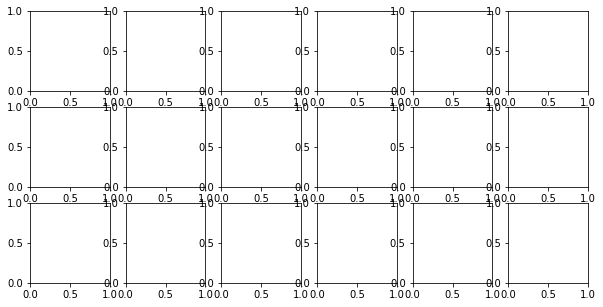

In [7]:
figure, axis = plt.subplots(3, repetitions+1, figsize=(10, 5))
for i in range(repetitions+1):
    axis[0][i].imshow(np.reshape(sim.data[input_probe][0, i], (28, 28)))
    axis[1][i].imshow(np.reshape(sim.data[encode_probe][0, i], (6, 6)))
    axis[2][i].imshow(np.reshape(sim.data[decode_probe][0, i], (28, 28)))